# Objetivo do projeto
#### Nosso objetivo aqui é identificar em qual bairro de Nova York é mais rentável comprar um imóvel para locação por dia, e construir um modelo de machine learning que faça a previsão de preços para os imóveis.

## Informações do conjunto de dados
<li> id – Atua como uma chave exclusiva para cada anúncio nos dados do aplicativo</li>
<li>nome - Representa o nome do anúncio</li>
<li>host_id - Representa o id do usuário que hospedou o anúncio</li>
<li>host_name – Contém o nome do usuário que hospedou o anúncio</li>
<li>bairro_group - Contém o nome do bairro onde o anúncio está localizado</li>
<li>bairro - Contém o nome da área onde o anúncio está localizado</li>
<li>latitude - Contém a latitude do local</li>
<li>longitude - Contém a longitude do local</li>
<li>room_type – Contém o tipo de espaço de cada anúncio</li>
<li>price - Contém o preço por noite em dólares listado pelo anfitrião</li>
<li>minimo_noites - Contém o número mínimo de noites que o usuário deve reservar</li>
<li>numero_de_reviews - Contém o número de comentários dados a cada listagem</li>
<li>ultima_review - Contém a data da última revisão dada à listagem</li>
<li>reviews_por_mes - Contém o número de avaliações fornecidas por mês</li>
<li>calculado_host_listings_count - Contém a quantidade de listagem por host</li>
<li>disponibilidade_365 - Contém o número de dias em que o anúncio está disponível para reserva</li>


In [232]:
#Import libraries
import numpy as np
import pandas as pd
import json
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Visual libraries
import matplotlib.pyplot as plt 
import seaborn as sns

#ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

#Save model
import pickle

%matplotlib inline

In [2]:
#Import csv file
path = 'https://raw.githubusercontent.com/DenisePotenza/Indicium/main/teste_indicium_precificacao.csv'
ny_rent = pd.read_csv(path, parse_dates=['ultima_review'])

#Show first five rows
ny_rent.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [3]:
#Dataset shape
print(f'Temos {ny_rent.shape[0]} linhas e {ny_rent.shape[1]} colunas no conjunto de dados.')

Temos 48894 linhas e 16 colunas no conjunto de dados.


In [4]:
#Dataset info
ny_rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             48894 non-null  int64         
 1   nome                           48878 non-null  object        
 2   host_id                        48894 non-null  int64         
 3   host_name                      48873 non-null  object        
 4   bairro_group                   48894 non-null  object        
 5   bairro                         48894 non-null  object        
 6   latitude                       48894 non-null  float64       
 7   longitude                      48894 non-null  float64       
 8   room_type                      48894 non-null  object        
 9   price                          48894 non-null  int64         
 10  minimo_noites                  48894 non-null  int64         
 11  numero_de_revie

In [5]:
#Missing data per column
((ny_rent.isnull().sum() / len(ny_rent)) * 100).sort_values(ascending=False)

ultima_review                    20.558760
reviews_por_mes                  20.558760
host_name                         0.042950
nome                              0.032724
id                                0.000000
host_id                           0.000000
bairro_group                      0.000000
bairro                            0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimo_noites                     0.000000
numero_de_reviews                 0.000000
calculado_host_listings_count     0.000000
disponibilidade_365               0.000000
dtype: float64

Temos quatro colunas com dados faltando, sendo ultima_review e reviews_por_mes com mais de 20% de entradas vazias.

In [6]:
#Numeric and categorical culumns
numeric = ["int16", "int32", "int64", "float16", "float32", "float64"]

#All numeric columns
numericas = ny_rent.select_dtypes(include=numeric)

#All categorical columns
categoricas = ny_rent.select_dtypes(exclude=numeric)

print(f"Temos {numericas.shape[1]} colunas numéricas e {categoricas.shape[1]} colunas categoricas.")


Temos 10 colunas numéricas e 6 colunas categoricas.


In [7]:
#Describe
ny_rent.describe().T

,count,mean,min,25%,50%,75%,max,std
id,48894.0,19017532.130609,2595.0,9472370.75,19677431.5,29152249.25,36487245.0,10982884.048876
host_id,48894.0,67621393.581605,2438.0,7822736.75,30795529.0,107434423.0,274321313.0,78611176.150486
latitude,48894.0,40.728951,40.49979,40.6901,40.723075,40.763117,40.91306,0.054529
longitude,48894.0,-73.952169,-74.24442,-73.98307,-73.95568,-73.936273,-73.71299,0.046157
price,48894.0,152.720763,0.0,69.0,106.0,175.0,10000.0,240.156625
minimo_noites,48894.0,7.030085,1.0,1.0,3.0,5.0,1250.0,20.510741
numero_de_reviews,48894.0,23.274758,0.0,1.0,5.0,24.0,629.0,44.550991
ultima_review,38842,2018-10-04 01:46:50.710055936,2011-03-28 00:00:00,2018-07-08 00:00:00,2019-05-19 00:00:00,2019-06-23 00:00:00,2019-07-08 00:00:00,NaN
reviews_por_mes,38842.0,1.373251,0.01,0.19,0.72,2.02,58.5,1.680453
calculado_host_listings_count,48894.0,7.144005,1.0,1.0,1.0,2.0,327.0,32.952855


In [8]:
ny_rent.describe(include='O')

,nome,host_name,bairro_group,bairro,room_type
count,48878,48873,48894,48894,48894
unique,47904,11452,5,221,3
top,Hillside Hotel,Michael,Manhattan,Williamsburg,Entire home/apt
freq,18,417,21661,3920,25409


# Perguntas:
* Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?
* O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?
* Existe algum padrão no texto do nome do local para lugares de mais alto valor?


In [9]:
#Properties by neigborhood
ny_rent['bairro_group'].value_counts()

bairro_group
Manhattan        21661
Brooklyn         20103
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

#### Manhattan e Brooklyn contém pouco mais de 85% dos imóveis no nosso dataset. Manhattan é considerada a ilha mais densamente povoada e mais cara de Nova York, onde encontramos ícones da cidade como Rockefeller Center, 5th Avenue, Central Park, além de ter a Ilha da Liberdade, casa de um dos símbolos de NYC, a Estátua da Liberdade. Já o Brooklyn é o condado mais populoso, sendo um bairro mais cultural, já foi palco de alguns filmes como Saturday Night Fever, além de museus e outras atrações.

## Outliers
#### Vejamos quais são os valores que estão fora do que é esperado para esse conjunto de dados.

In [10]:
def quantile_calculate(price: pd.Series) -> float:
    '''Get a Pandas Series containing price values. Calculate and return the minimum and maximum values using quantiles and IQR.'''
    q1 = price.quantile(.25)
    q3 = price.quantile(.75)

    IQR = q3-q1

    min = q1 - 1.5 * IQR
    max = q3 + 1.5 * IQR

    return min, max

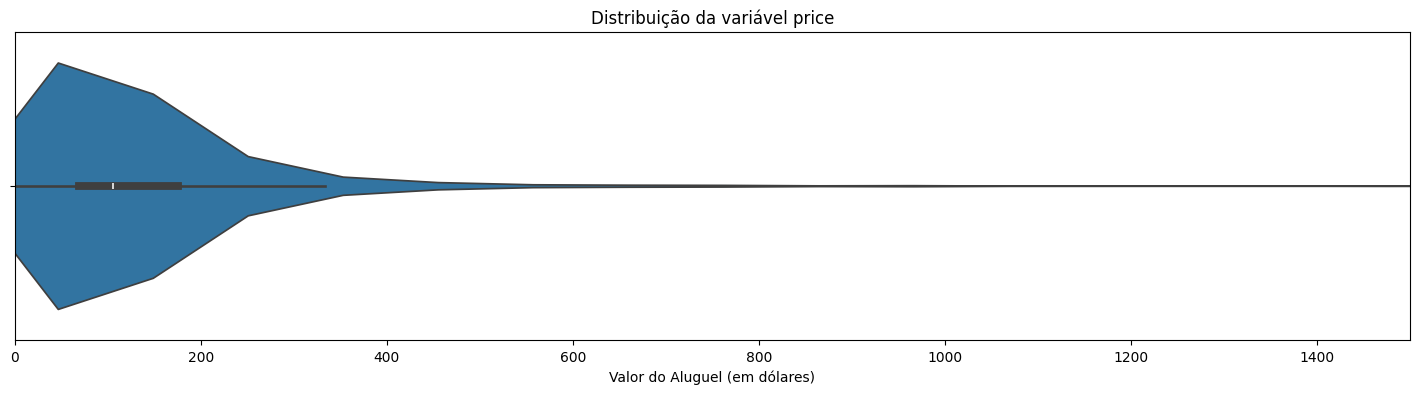

In [11]:
#Create a figure to plot
figure, ax = plt.subplots(figsize=(18,4))

#Create a violinplot
sns.violinplot(x=ny_rent['price'], ax=ax, )
ax.set_xlim(0, 1500)
plt.xlabel('Valor do Aluguel (em dólares)')
plt.title('Distribuição da variável price')

plt.show()


#### No gráfico acima conseguimos ver que boa parte dos valores está em um intervalo esperado, e que há alguns valores que são bem maiores. Calculamos qual seria o valor máximo para esse conjunto de dados e ver o que está além desse valor.

In [12]:
#Set minimum and maximum price
min_price, max_price = quantile_calculate(ny_rent['price'])
print(f"Preço mínimo: US$ {min_price} \nPreço máximo: US$ {max_price}.")

Preço mínimo: US$ -90.0 
Preço máximo: US$ 334.0.


#### Usando a técnica de quartis e interquartil, conseguimos definir um valor mínimo de US$ −90,00 e um valor máximo de US$ 334,00 para nosso conjunto de dados. Logicamente não consideramos o valor mínimo por ser negativo, apesar de termos 11 entradas com aluguel de US$ 0,00, acredito que seja um erro do host na hora de publicar o anúncio, portanto usaremos o valor mínimo de US$ 11,00. Por outro lado, tudo o que estiver acima de US$ 334,00 pode ser considerado como outlier.

In [13]:
print(f'Temos {ny_rent.query("price > 334.0").shape[0]} entradas que estão acima de 334 dólares. \
Pouco mais de 6% das entradas do nosso conjunto de dados.')

Temos 2972 entradas que estão acima de 334 dólares. Pouco mais de 6% das entradas do nosso conjunto de dados.


#### Essa quantidade de aluguéis que estão acima de 334 dólares explica a diferença entre a média e a mediana da variável price. A média é 30% maior que a mediana.

In [14]:
#Outliers per neighborhood
ny_rent.query('price > 334.0').groupby('bairro_group')['bairro_group'].value_counts().sort_values(ascending=False)

bairro_group
Manhattan        2155
Brooklyn          689
Queens             99
Bronx              21
Staten Island       8
Name: count, dtype: int64

#### Como esperado, a maioria dos valores acima de US$ 334,00 está na ilha de Manhattan. A que mais aparece é Midtown, onde estão localizados os pontos mais famosos de Nova York. Porém, mesmo nessa área é possível encontrar aluguéis com valor abaixo de US$ 334,00 que estão bem localizados. Em seguida, sem novidades, também temos uma grande quantidade de imóveis acima do esperado no Brooklyn. Sendo as duas regiões que mais tem entradas no nosso conjunto de dados, faz sentido que tenham mais outliers também.

In [15]:
#Average price per neighborhood, properties above US$ 334
ny_rent.query('price < 334.0').groupby('bairro_group')['price'].median().sort_values()

bairro_group
Bronx             65.0
Queens            74.0
Staten Island     75.0
Brooklyn          90.0
Manhattan        135.0
Name: price, dtype: float64

#### Considerando a mediana, Manhattan é o bairro com o maior valor por imóvel. Mas devemos considerar outras variáveis para determinar se realmente é a melhor local para investir em imóvel para locação.

#### Daremos uma olhada na coluna ultima_review, ver quanto porcento a última review foi antes de 2019 e qual a porcentagem que obteve uma review nos últimos 6 meses no dataset.

In [16]:
#Average ultima_review over 6 months ago and the last 6 months
six_months = ny_rent.query('ultima_review < "2019-01-01" and disponibilidade_365 != 0')['bairro_group'].value_counts().to_frame()\
   .reset_index()
six_months.rename(columns={'bairro_group': 'bairro_group', 'count': 'over_6_months'}, inplace=True)
neighborhoods = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
for n in neighborhoods:
   six_months.loc[six_months['bairro_group'] == n, 'last_6_months'] = ny_rent[(ny_rent['ultima_review'] >= '2019-01-01') \
                                 & (ny_rent['bairro_group'] == n) & (ny_rent['disponibilidade_365'] != 0)].shape[0]
   six_months.loc[six_months['bairro_group'] == n, 'total_original'] = ny_rent[ny_rent['bairro_group'] == n].shape[0]
   six_months.loc[six_months['bairro_group'] == n, 'total_missing(%)'] = round((ny_rent[ny_rent['bairro_group'] == n]\
                     ['ultima_review'].isnull().sum() / ny_rent[ny_rent['bairro_group'] == n].shape[0] * 100), 2)

six_months ['mean_over'] = round((six_months['over_6_months'] / six_months['total_original'] * 100), 2)
six_months ['mean_last'] = round((six_months['last_6_months'] / six_months['total_original'] * 100), 2)
six_months

,bairro_group,over_6_months,last_6_months,total_original,total_missing(%),mean_over,mean_last
0,Manhattan,1824,8989.0,21661.0,23.22,8.42,41.50
1,Brooklyn,1635,9028.0,20103.0,18.19,8.13,44.91
2,Queens,454,3181.0,5666.0,19.27,8.01,56.14
3,Bronx,87,669.0,1091.0,19.71,7.97,61.32
4,Staten Island,33,254.0,373.0,15.82,8.85,68.10


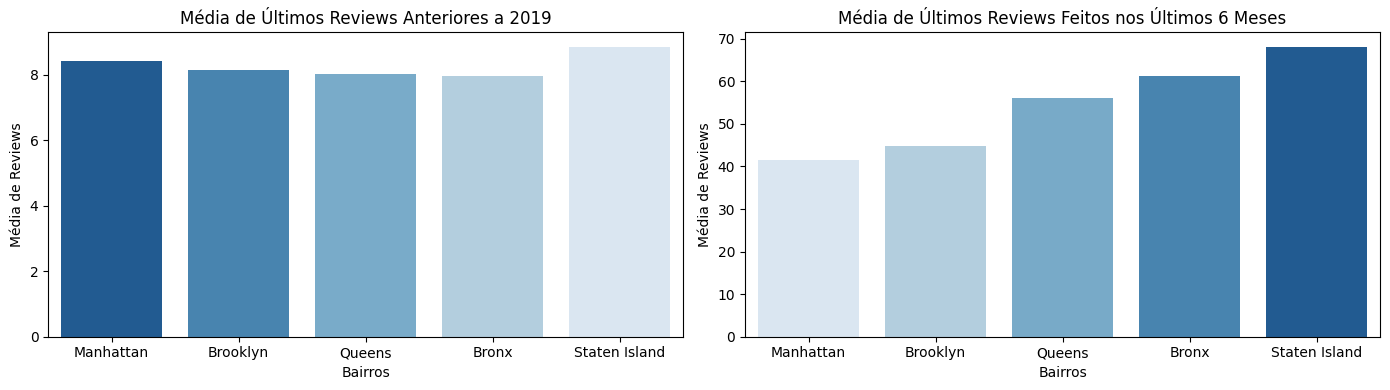

In [17]:
#Create a figure to plot
fig, axs =plt.subplots(ncols=2, figsize=(14,4))

#Plot 2 histograms
sns.barplot(x=six_months['bairro_group'], y=six_months['mean_over'], hue=six_months['bairro_group'], ax=axs[0], palette='Blues_r')
sns.barplot(x=six_months['bairro_group'], y=six_months['mean_last'], hue=six_months['bairro_group'],ax=axs[1], palette='Blues')
axs[0].set_xlabel('Bairros')
axs[0].set_ylabel('Média de Reviews')
axs[0].set_title('Média de Últimos Reviews Anteriores a 2019')

axs[1].set_xlabel('Bairros')
axs[1].set_ylabel('Média de Reviews')
axs[1].set_title('Média de Últimos Reviews Feitos nos Últimos 6 Meses')

plt.tight_layout();

#### No gráfico acima, o primeiro gráfico mostra que a média de últimos reviews que foram feitos antes de 2019 é praticamente igual em todos os bairros, porém quando olhamos para o segundo gráfico, que traz a média de últimos reviews dos últimos 6 meses, Staten Island é tem uma vantagem considerável sobre Manhattan e Brooklyn. Essa média foi calculada ignorando os imóveis que tem como disponibilidade de dias igual a 0, se não estão disponíveis para alugar, não tem como alguém fazer review por aluguel do apartamento.
#### Levando isso em consideração, já podemos pensar se realmente Manhattan é o local mais apropriado para investir em um imóvel.

#### Abaixo temos alguns aquivos json que armazenam a média do valor de compra de imóveis por bairro, esses valores foram tirados do site [Zillow]('https://www.zillow.com/home-values/102001/united-states/). Usaremos esses valores para calcular quais os bairros valem o investir em um imóvel.

In [18]:
#Read json files
def read_json(json_file: json) -> dict:
    '''Get a json file and return as a dict'''
    with open(json_file, 'r') as file:
        j_file = json.load(file)
    
    return j_file

In [19]:
#Json files containing the mean price per neighborhood
manhattan_mean_price = read_json('Json Files/manhattan_mean_price.json')
brooklyn_mean_price = read_json('Json Files/brooklyn_mean_price.json')
bronx_mean_price = read_json('Json Files/bronx_mean_price.json')
queens_mean_price = read_json('Json Files/queens_mean_price.json')
st_island_mean_price = read_json('Json Files/staten_island_mean_price.json')

#### Criamos uma variável para cada um dos grandes bairros de Nova York, Manhattan, Brooklyn, Bronx, Queens e Staten Island que estão armazenadas na variável bairro_group.
#### Para cada nova variável temos:
 * bairro
 * mediana de preço para aquele bairro no conjunto de dados
 * mediana de preço de compra de imóveis obtidas dos arquivos json, 
 * qual o valor esperado por diária para poder considerarmos o imóvel rentável
 * lucro, calculado subtraindo o valor esperado do preço
 #### Uma das regras considerada para calcular se devemos ou não investir em um imóvel seria obter um aluguel mensal de 1% do valor pago pelo imóvel. Contudo, nosso intuito aqui é alugar considerando a diária, portanto esse valor foi dividido por 30 e assim temos uma média do valor que deveria ser cobrado por dia para que o imóvel se torne um investimento atrativo.


In [20]:
#Create a dataframe for each burough
#Manhattan
manhattan = round(ny_rent.query('bairro_group == "Manhattan" and disponibilidade_365 != 0 and room_type == "Entire home/apt"')\
                  .groupby('bairro')['price'].median(), 2).sort_values().to_frame().reset_index()
manhattan['média_preço_compra(US$)'] = manhattan['bairro'].map(manhattan_mean_price)
manhattan['1%'] = round(manhattan['média_preço_compra(US$)'] * 0.01 / 30, 2)
manhattan['lucro'] = manhattan['price'] - manhattan['1%']

#Brooklyn
brooklyn = round(ny_rent.query('bairro_group == "Brooklyn" and disponibilidade_365 != 0 and room_type == "Entire home/apt"')\
                 .groupby('bairro')['price'].median(), 2).sort_values().to_frame().reset_index()
brooklyn['média_preço_compra(US$)'] = brooklyn['bairro'].map(brooklyn_mean_price)
brooklyn['1%'] = round(brooklyn['média_preço_compra(US$)'] * 0.01 / 30, 2)
brooklyn['lucro'] = brooklyn['price'] - brooklyn['1%']

#Bronx
bronx = round(ny_rent.query('bairro_group == "Bronx" and disponibilidade_365 != 0 and room_type == "Entire home/apt"')\
              .groupby('bairro')['price'].median(), 2).sort_values().to_frame().reset_index()
bronx['média_preço_compra(US$)'] = bronx['bairro'].map(bronx_mean_price)
bronx['1%'] = round(bronx['média_preço_compra(US$)'] * 0.01 / 30, 2)
bronx['lucro'] = bronx['price'] - bronx['1%']

#Queens
queens = round(ny_rent.query('bairro_group == "Queens" and disponibilidade_365 != 0 and room_type == "Entire home/apt"')\
               .groupby('bairro')['price'].median(), 2).sort_values().to_frame().reset_index()
queens['média_preço_compra(US$)'] = queens['bairro'].map(queens_mean_price)
queens['1%'] = round(queens['média_preço_compra(US$)'] * 0.01 / 30, 2)
queens['lucro'] = queens['price'] - queens['1%']

#Staten Island
st_island = round(ny_rent.query('bairro_group == "Staten Island" and disponibilidade_365 != 0 and room_type == "Entire home/apt"')\
                  .groupby('bairro')['price'].median(), 2).sort_values().to_frame().reset_index()
st_island['média_preço_compra(US$)'] = st_island['bairro'].map(st_island_mean_price)
st_island['1%'] = round(st_island['média_preço_compra(US$)'] * 0.01 / 30, 2)
st_island['lucro'] = st_island['price'] - st_island['1%']

#### Verifiquemos quais bairros em cada grande bairro tem o valor da coluna price maior do que o valor que calculamos de 1%.

In [21]:
#Where a rental property is profitable
print(manhattan[manhattan['price'] > manhattan['1%']], '\n')
print(brooklyn[brooklyn['price'] > brooklyn['1%']], '\n')
print(bronx[bronx['price'] > bronx['1%']], '\n')
print(queens[queens['price'] > queens['1%']], '\n')
print(st_island[st_island['price'] > st_island['1%']], '\n')

Empty DataFrame
Columns: [bairro, price, média_preço_compra(US$), 1%, lucro]
Index: [] 

          bairro  price  média_preço_compra(US$)      1%  lucro
45  Vinegar Hill  200.0                   451434  150.48  49.52 

               bairro  price  média_preço_compra(US$)      1%  lucro
3          Highbridge   76.0                   219741   73.25   2.75
9         Parkchester   88.0                   205543   68.51  19.49
17        Kingsbridge   99.0                   291734   97.24   1.76
25         Mount Hope  105.0                   250944   83.65  21.35
31  Concourse Village  115.0                   304945  101.65  13.35
34          Riverdale  124.5                   362119  120.71   3.79
37            Norwood  125.0                   366919  122.31   2.69
41         West Farms  165.0                   439582  146.53  18.47
42        Eastchester  202.5                   545861  181.95  20.55
43            Belmont  247.0                   470459  156.82  90.18 

           bairro  p

#### Levando o cálculo acima, vemos que Manhattan, apesar de ter os valores mais altos, não é o local mais indicado para comprar um imóvel devido ao alto valor de compra dos mesmos. Tanto que não tem nenhum bairro que tenha o valor na coluna price que seja maior que o valor calculado de 1%. 
#### Bronx é a área que tem a maior quantidade de bairros com imóveis rentáveis.


In [22]:
#Concat all the neighborhoods and profits
buroughs = [manhattan[manhattan['price'] > manhattan['1%']][['bairro', 'lucro']], 
            brooklyn[brooklyn['price'] > brooklyn['1%']][['bairro', 'lucro']], 
            bronx[bronx['price'] > bronx['1%']][['bairro', 'lucro']], queens[queens['price'] > queens['1%']][['bairro', 'lucro']], 
            st_island[st_island['price'] > st_island['1%']][['bairro', 'lucro']]]

new_york = pd.concat(buroughs)

In [23]:
#From less to more profitable
print("Ranking de bairro de acordo com o lucro oferecido.")
new_york.sort_values(by='lucro')

Ranking de bairro de acordo com o lucro oferecido.


,bairro,lucro
31,Kew Gardens,1.56
17,Kingsbridge,1.76
37,Norwood,2.69
3,Highbridge,2.75
34,Riverdale,3.79
48,Jamaica Hills,5.95
31,Concourse Village,13.35
41,West Farms,18.47
9,Parkchester,19.49
42,Eastchester,20.55


#### Acima temos um ranking do lucro diário de cada bairro.

#### Comparando os bairros acima com o dataset, segue ranking de melhores oportunidades. Aqui consideramos o aluguel do imóvel como todo ou um imóvel com pelo menos 3 dormitórios para alugar por quarto.

<style>
    table, td, th{
        text-align: center;
    }
</style>

<table>
    <tr><th colspan="5"><font size='4,5'> Bairros mais vantajosos</i> </th></tr>
    <tr><th> Bairro </th><th> Imóveis Dentro do Preço </th><th> Total de Imóveis </th><th> Região </th><th> Lucro </th>
    <tr><th> Parkchester </th><td> 31 </td><td> 31 </td><td> Bronx </td><td> US$ 19.49</td> </tr>
    <tr><th> Vinegar Hill </th><td> 21 </td><td> 21 </td><td> Brooklyn </td><td> US$ 49.52</td> </tr>
    <tr><th> Mount Hope </th><td> 16 </td><td> 16 </td><td> Bronx </td><td> US$ 21.35</td> </tr>
    <tr><th> Concourse Village</th><td> 24 </td><td> 24</td><td> Bronx </td><td> US$ 13.35</td> </tr>
    <tr><th> Riverdale </th><td> 8 </td><td> 8  </td><td> Bronx </td><td> US$ 3.79</td> </tr>
    <tr><th> Kingsbridge</th><td> 56 </td><td> 58</td><td> Bronx </td><td> US$ 1.76</td> </tr>
    <tr><th> Belmont </th><td> 9 </td><td> 17 </td><td> Bronx </td><td> US$ 90.18 </td></tr>
    <tr><th> Eastchester </th><td> 11 </td><td> 13 </td><td> Bronx </td><td> US$ 20.55 </td></tr>
    <tr><th> West Farms </th><td> 2 </td><td> 2 </td><td> Bronx </td><td> US$ 18.47 </td></tr>
    <tr><th> Jamaica Hills </th><td> 4 </td><td> 6 </td><td> Queens </td><td> US$ 5.95 </td></tr>
    <tr><th> Highbridge </th><td> 22 </td><td> 24 </td><td> Bronx </td><td>US$ 2.75 </td></tr>
    <tr><th> Norwood </th><td> 19 </td><td> 22 </td><td> Bronx </td><td> US$ 2.69 </td></tr>
    <tr><th> Kew Gardens </th><td> 24 </td><td> 26 </td><td> Queens </td><td> US$ 1.56 </td></tr>
    <tr><th> Bayside </th><td> 23 </td><td> 36 </td><td> Queens </td><td> US$ 30.02 </td></tr>
    <tr><th> Far Rockaway </th><td> 11 </td><td> 25 </td><td> Queens </td><td> US$ 41.14 </td></tr>
</table>

#### Aqui consideramos somente os imóveis que tem disponibilidade de locação maior do que 0 dias, pois mais da metade dos imóveis no conjunto de dados com 0 dias disponíveis tem a última review feita antes do ano de 2019. Talvez isso se deva ao anúncio estar inativo, portanto o preço de aluguel desse imóvel pode estar depreciado.
#### Para determinar qual o melhor bairro para comprar um imóvel, outras variáveis externas deveriam ser consideradas, como impostos cobrados por região. No caso de Nova York, considerando as regiões acima, Brooklyn é o que tem o menor imposto, 0.700%, seguido pelo Queens, 0.890% e Bronx, a região com maior imposto, 1.020%. Podemos considerar também o gráfico que postamos mais acima, onde mostra que a porcentagem de reviews mais recentes, é maior no Bronx do que no Brooklyn, por exemplo. Considerando apenas essa variáveis, a região do Bronx, apesar do maior imposto, parece mais atrativa, pois vemos que todas as ocorrências no conjunto de dados que se encaixam nos bairros da região tem uma taxa de lucro considerável, podendo chegar a aproximadamente 1.58% do valor de compra do imóvel por mês.


*As taxas de cada região foram tiradas da [Smart Asset](https://smartasset.com/taxes/new-york-property-tax-calculator#:~:text=When%20taking%20those%20exemptions%20into,%2C%20the%20rate%20is%200.98%25).

# Numero de Noites x Preço e Disponibilidade x Preço

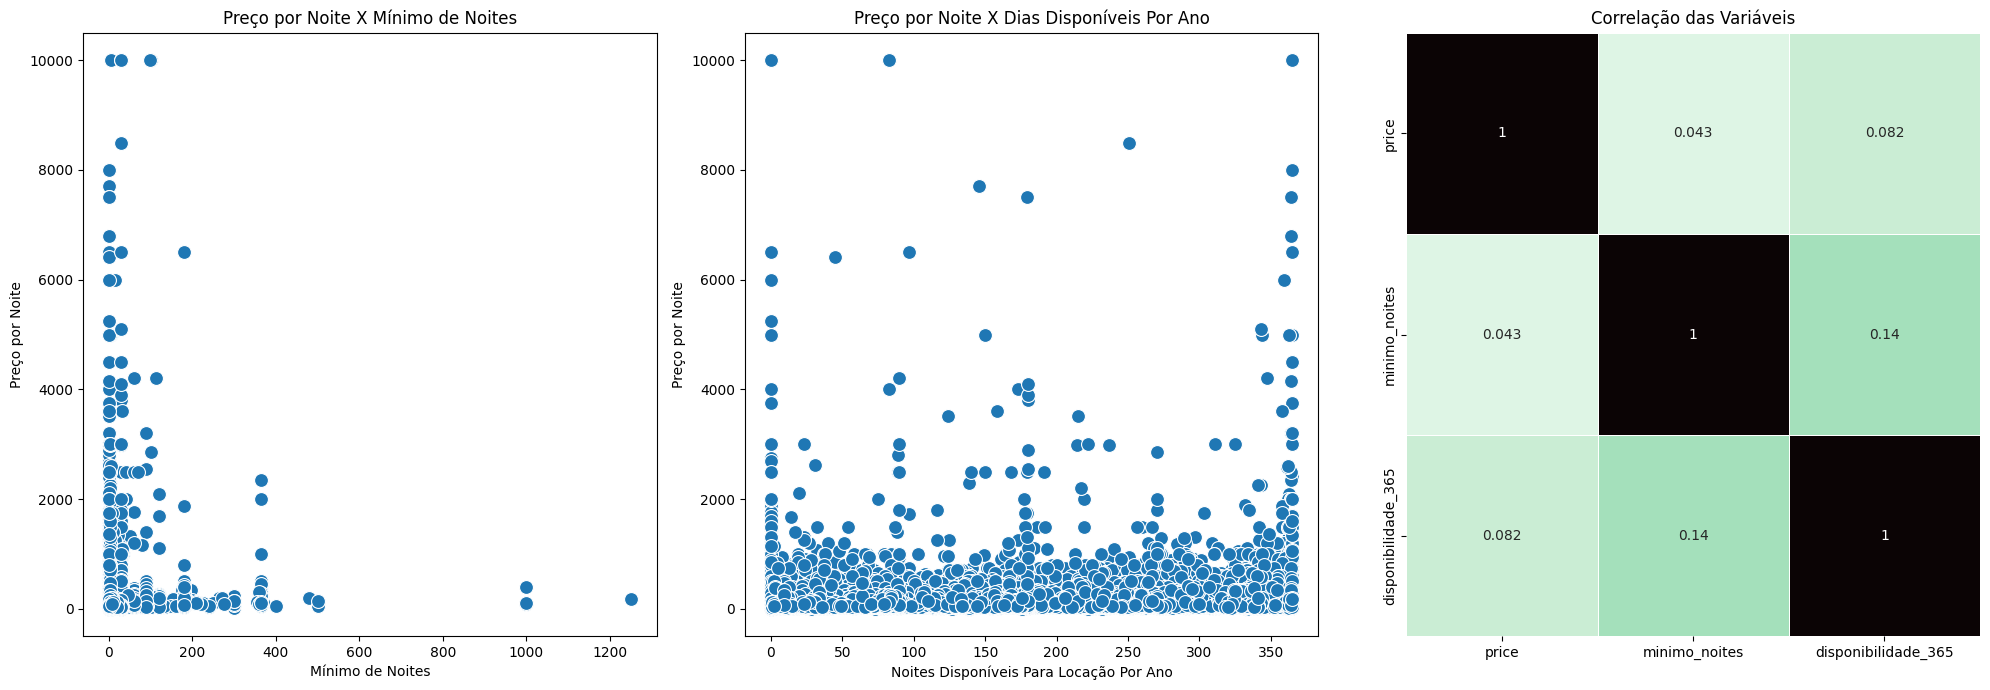

In [24]:
#Create a figure to plot
fig, axs = plt.subplots(ncols=3, figsize=(20,7))

corr = ny_rent[['price', 'minimo_noites', 'disponibilidade_365']].corr()

sns.scatterplot(x=ny_rent['minimo_noites'], y=ny_rent['price'], s=100, ax=axs[0])
sns.scatterplot(x=ny_rent['disponibilidade_365'], y=ny_rent['price'], s=100, ax=axs[1])
sns.heatmap(corr, annot=True, linewidths=.4, cbar=False, cmap='mako_r', ax=axs[2])

axs[0].set_xlabel('Mínimo de Noites')
axs[0].set_ylabel('Preço por Noite')
axs[0].set_title('Preço por Noite X Mínimo de Noites')
axs[1].set_xlabel('Noites Disponíveis Para Locação Por Ano')
axs[1].set_ylabel('Preço por Noite')
axs[1].set_title('Preço por Noite X Dias Disponíveis Por Ano')
axs[2].set_title('Correlação das Variáveis')

plt.tight_layout();


#### Com os gráficos acima conseguimos ver que não existe uma correlação forte entre as variáveis minimo_de_noites e disponibilidade_365 e a variável price. Os valores estão distribuídos de forma homogênea. Portanto, essas duas variáveis não influenciam expressivamente no preço do imóvel.

# Padrão no texto de imóveis de alto valor

#### Será que existe algum padrão no texto do nome dos imóveis de alto valor?
#### É complicado definir um valor para dividir o conjunto de dados. O valor máximo que tínhamos encontrado acima foi de US$ 334,00, porém aqui consideremos imóveis acima de US$ 500,00 como de alto valor.


In [25]:
#Define and update stopwords
stopwords = set(STOPWORDS)
stopwords.update(["—", '-', '&', '+', '', '!', '.', '...', ':', '|', 'w/', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0'])

In [26]:
def lower_split(nome: pd.Series) -> pd.Series:
    '''Put the string in lower caption and split it in a list of words'''
    return nome.lower().split(' ')

In [27]:
def join_list(list: list) -> list:
    '''Return a unique list from multiple lists'''
    words_count = []
    for line in list:
        words_count.extend(line)
    return words_count

In [28]:
def wordcloud_img(words_low: str, words_high: str, stop: str=stopwords) -> None:
    '''Plot 2 wordcloud images, one for apartments priced below US$334 and one for apartments priced above US$334'''
    wordcloud = WordCloud(stopwords=stop).generate(words_low)
    wordcloud_high = WordCloud(stopwords=stop).generate(words_high)

    fig,axs=plt.subplots(ncols=2, figsize=(20,10))

    axs[0].imshow(wordcloud, interpolation='bilinear')
    axs[0].set_title('Apartamentos até US$ 334')
    axs[1].imshow(wordcloud_high, interpolation='bilinear')
    axs[1].set_title("Apartamentos acima de US$ 334")
    plt.tight_layout();

In [29]:
#Store a list of each description in the 'nome' variable
low_cost = ny_rent[(ny_rent['price'] <= 500) & (~ny_rent['nome'].isna())]['nome'].apply(lower_split)
high_cost = ny_rent[(ny_rent['price'] > 500) & (~ny_rent['nome'].isna())]['nome'].apply(lower_split)

In [30]:
#Get a unique list of low and high cost apartments
low_cost_words = join_list(low_cost)
high_cost_words = join_list(high_cost)

#Count every word of each list
count_low = Counter(low_cost_words)
count_high = Counter(high_cost_words)

#Put all words into a unique string format
low_cost_words = ' '.join(word for word in low_cost_words)
high_cost_words = ' '.join(word for word in high_cost_words)

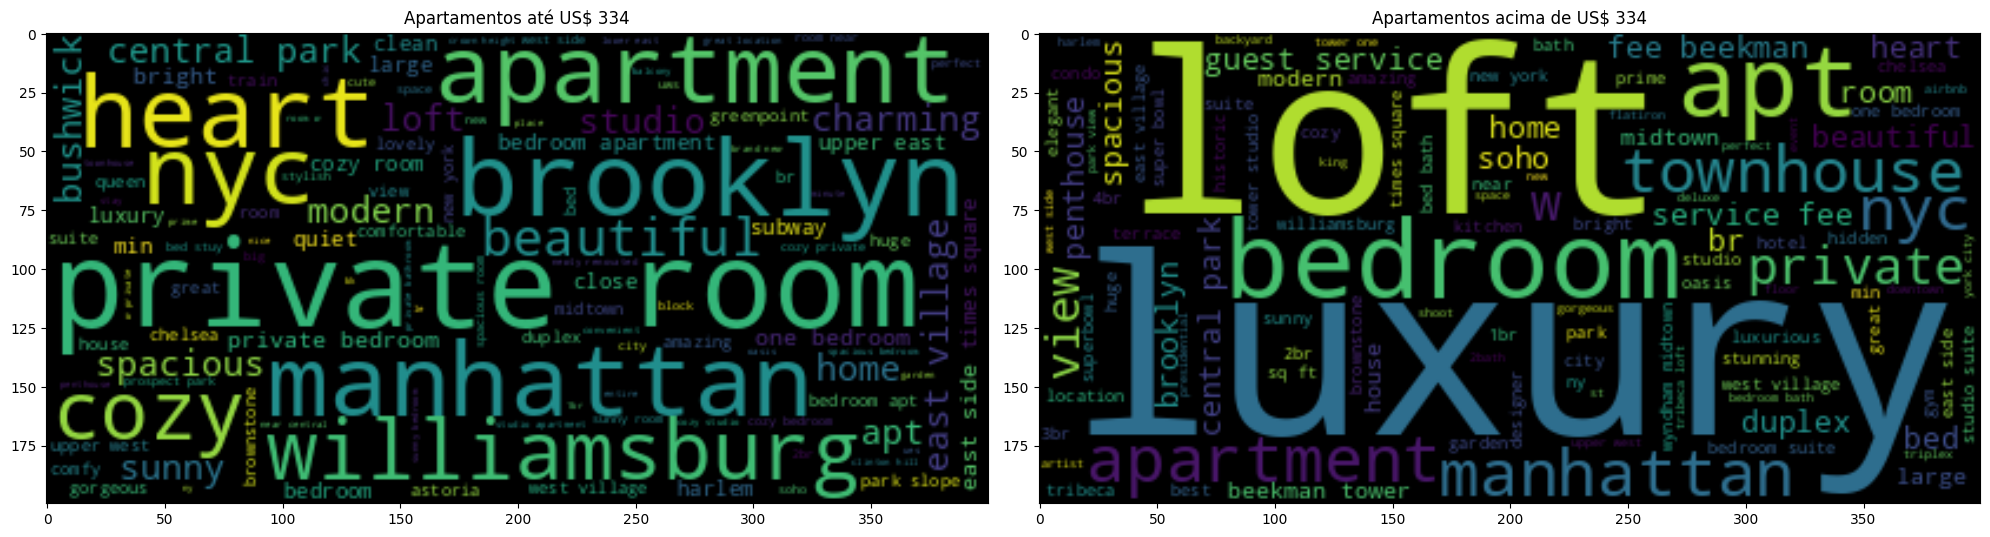

In [31]:
#Plot wordcloud
wordcloud_img(low_cost_words, high_cost_words)

In [32]:
#Remove the words in stopwords list from count_low and count_high
def remove_stopwords(words_list: list, stop = stopwords) -> list:
    ''''Remove the words in the stopwords variable from the list and return it'''
    for word in stopwords:
        try:
            words_list.pop(word)
        except:
            pass
    return words_list

In [33]:
def words_frequency(counted_high: dict, counted_low: dict,  df_high_shape: int, df_low_shape: int) -> dict:
    '''Receives two Counter dictionaries to get the 30 most frequent words for high cost features and calculates the frequency of 
    each word according to the data frame size.'''
    most_common_high = counted_high.most_common()[:30]
    high_freq = {}
    low_freq = {}
    for most_common in most_common_high:
        high_freq[most_common[0]] = round(counted_high[most_common[0]] / df_high_shape * 100, 2)

        if most_common[0] in counted_low:
            low_freq[most_common[0]] = round(counted_low[most_common[0]] / df_low_shape * 100, 2)
    return high_freq, low_freq

In [34]:
#Use remove_stopwords
count_low = remove_stopwords(count_low)
count_high = remove_stopwords(count_high)

In [35]:
print("5 palavras mais comuns em apartamentos abaixo de US$500:\n",count_low.most_common()[:5])
print("5 palavras mais comuns em apartamentos acima de US$500:\n",count_high.most_common()[:5])

5 palavras mais comuns em apartamentos abaixo de US$500:
 [('room', 9348), ('bedroom', 7101), ('private', 6917), ('apartment', 6036), ('cozy', 4617)]
5 palavras mais comuns em apartamentos acima de US$500:
 [('bedroom', 127), ('luxury', 121), ('loft', 101), ('apartment', 72), ('suite', 69)]


In [36]:
#Calculates the frequency of each word
high_freq, low_freq = words_frequency(count_high, count_low, 
                                      ny_rent[ny_rent['price'] >=334].shape[0], ny_rent[ny_rent['price'] < 334].shape[0])
print(f'Frequencia das 30 palavras mais usadas em imóveis de alto custo em imóveis abaixo de US$ 334: \n {low_freq}')
print(f'Frequencia das 30 palavras mais usadas em imóveis de alto custo: \n {high_freq}')

Frequencia das 30 palavras mais usadas em imóveis de alto custo em imóveis abaixo de US$ 334: 
 {'bedroom': 15.46, 'luxury': 3.25, 'loft': 3.74, 'apartment': 13.15, 'suite': 1.21, 'townhouse': 0.82, 'apt': 7.63, 'private': 15.06, 'manhattan': 6.08, 'village': 4.34, 'nyc': 3.77, 'park': 5.6, 'west': 3.19, 'midtown': 2.38, 'brooklyn': 7.78, 'studio': 8.1, 'new': 3.03, 'service': 0.03, 'guest': 0.42, 'central': 3.63, 'beautiful': 4.95, 'duplex': 1.61, 'east': 6.37, 'bath': 1.61, 'penthouse': 0.74, 'spacious': 7.29, 'heart': 4.37, 'large': 4.02}
Frequencia das 30 palavras mais usadas em imóveis de alto custo: 
 {'bedroom': 4.27, 'luxury': 4.06, 'loft': 3.39, 'apartment': 2.42, 'suite': 2.32, 'townhouse': 2.28, 'apt': 2.22, 'private': 2.18, 'manhattan': 2.08, 'village': 2.05, 'nyc': 2.02, 'park': 1.88, 'west': 1.88, 'midtown': 1.85, 'brooklyn': 1.81, 'studio': 1.78, 'new': 1.75, 'service': 1.68, 'guest': 1.68, '*no': 1.65, 'fee*': 1.65, 'central': 1.55, 'beautiful': 1.48, 'duplex': 1.44, 'e

#### Aparentemente, olhando o conjunto de dados na totalidade, vemos que existe sim alguma diferença nas palavras usadas em imóveis com valor mais elevado, porém nada expressivo. Mas será que se separarmos por tipo de imóvel oferecido isso se mantém?
#### A seguir faremos os mesmos passos adotados acima, só que dessa vez separaremos por tipo de imóvel, apartamento inteiro, quarto privado e quarto compartilhado.


# Aluguel do imóvel todo

In [37]:
#Get the maximum value 
entire_min, entire_max = quantile_calculate(ny_rent.query("room_type == 'Entire home/apt' and ultima_review >= '2018-07-08'")['price'])
print(f'Para imóveis que serão alugados por inteiro temos o valor máximo de US$ {entire_max}, \
usaremos no caso um valor arredondado de US$ 400.00')

Para imóveis que serão alugados por inteiro temos o valor máximo de US$ 384.0, usaremos no caso um valor arredondado de US$ 400.00


In [38]:
#List of words
entire_low_cost = ny_rent[(~ny_rent['nome'].isna()) &
                          (ny_rent['room_type'] == 'Entire home/apt') & 
                          (ny_rent['price'] < 400)]['nome'].apply(lower_split)

entire_high_cost = ny_rent[(~ny_rent['nome'].isna()) & 
                           (ny_rent['room_type'] == 'Entire home/apt') & 
                           (ny_rent['price'] >= 400)]['nome'].apply(lower_split)

In [39]:
#Get a unique list of low and high cost apartments
entire_low_cost_words = join_list(entire_low_cost)
entire_high_cost_words = join_list(entire_high_cost)

#Count every word of each list
entire_count_low = Counter(entire_low_cost_words)
entire_count_high = Counter(entire_high_cost_words)

#Put all words into a unique string format
entire_low_cost_words = ' '.join(word for word in entire_low_cost_words)
entire_high_cost_words = ' '.join(word for word in entire_high_cost_words)

In [40]:
#Use remove_stopwords
entire_count_low = remove_stopwords(entire_count_low)
entire_count_high = remove_stopwords(entire_count_high)

In [41]:
#Print 5 most common words
print("5 palavras mais comuns em apartamentos abaixo de US$400:\n",entire_count_low.most_common()[:5])
print("5 palavras mais comuns em apartamentos acima de US$400:\n",entire_count_high.most_common()[:5])

5 palavras mais comuns em apartamentos abaixo de US$400:
 [('apartment', 4287), ('studio', 3398), ('bedroom', 3235), ('apt', 2511), ('cozy', 1844)]
5 palavras mais comuns em apartamentos acima de US$400:
 [('bedroom', 209), ('luxury', 207), ('loft', 197), ('apartment', 167), ('apt', 124)]


In [42]:
#Calculates the frequency of each word
high_freq, low_freq = words_frequency(entire_count_high, 
                                      entire_count_low, 
                                      ny_rent[(ny_rent['room_type'] == 'Entire home/apt') & 
                                              (ny_rent['price'] >= 400)].shape[0], 
                                      ny_rent[(ny_rent['room_type'] == 'Entire home/apt') &
                                              (ny_rent['price'] < 400)].shape[0])

print(f'Frequencia das 30 palavras mais usadas para imóveis de alto custo em imóveis abaixo de US$ 400: \n {low_freq}')
print(f'Frequencia das 30 palavras mais usadas em imóveis de alto custo: \n {high_freq}')

Frequencia das 30 palavras mais usadas para imóveis de alto custo em imóveis abaixo de US$ 400: 
 {'bedroom': 13.67, 'luxury': 4.17, 'loft': 4.17, 'apartment': 18.11, 'apt': 10.61, 'village': 5.73, 'west': 4.2, 'manhattan': 5.08, 'townhouse': 1.03, 'park': 6.56, 'brooklyn': 7.75, 'nyc': 3.85, 'east': 7.6, 'duplex': 2.02, 'private': 5.23, 'beautiful': 5.12, 'central': 3.81, 'new': 3.22, 'bath': 1.19, 'studio': 14.36, 'spacious': 7.66, 'midtown': 2.99, 'soho': 0.96, 'large': 3.51, 'modern': 4.58, 'suite': 1.1, 'bed': 2.58, '2br': 2.1, 'williamsburg': 4.72, 'amazing': 1.83}
Frequencia das 30 palavras mais usadas em imóveis de alto custo: 
 {'bedroom': 12.03, 'luxury': 11.91, 'loft': 11.33, 'apartment': 9.61, 'apt': 7.13, 'village': 6.67, 'west': 5.87, 'manhattan': 5.7, 'townhouse': 5.64, 'park': 5.58, 'brooklyn': 5.52, 'nyc': 5.52, 'east': 5.35, 'duplex': 5.12, 'private': 4.89, 'beautiful': 4.6, 'central': 4.49, 'new': 4.43, 'bath': 4.32, 'studio': 4.03, 'spacious': 3.91, 'midtown': 3.91,

## Private room

In [43]:
#Get the maximum value 
entire_min, entire_max = quantile_calculate(ny_rent.query("room_type == 'Private room' and ultima_review >= '2018-07-08'")['price'])
print(f'Para imóveis que serão alugados somente um quarto temos o valor máximo de US$ {entire_max}, \
usaremos no caso um valor arredondado de US$ 200.00')

Para imóveis que serão alugados somente um quarto temos o valor máximo de US$ 161.0, usaremos no caso um valor arredondado de US$ 200.00


In [44]:
#List of words
private_low_cost = ny_rent[(~ny_rent['nome'].isna()) &
                          (ny_rent['room_type'] == 'Private room') & 
                          (ny_rent['price'] < 200)]['nome'].apply(lower_split)

private_high_cost = ny_rent[(~ny_rent['nome'].isna()) & 
                           (ny_rent['room_type'] == 'Private room') & 
                           (ny_rent['price'] >= 200)]['nome'].apply(lower_split)

In [45]:
#Get a unique list of low and high cost apartments
private_low_cost_words = join_list(private_low_cost)
private_high_cost_words = join_list(private_high_cost)

#Count every word of each list
private_count_low = Counter(private_low_cost_words)
private_count_high = Counter(private_high_cost_words)

#Put all words into a unique string format
private_low_cost_words = ' '.join(word for word in private_low_cost_words)
private_high_cost_words = ' '.join(word for word in private_high_cost_words)

In [47]:
#Use remove_stopwords
private_count_low = remove_stopwords(private_count_low)
private_count_high = remove_stopwords(private_count_high)

In [48]:
#Print 5 most common words
print("5 palavras mais comuns para aluguel de quartos abaixo de US$200:\n",private_count_low.most_common()[:5])
print("5 palavras mais comuns para aluguel de quartos acima de US$200:\n",private_count_high.most_common()[:5])

5 palavras mais comuns para aluguel de quartos abaixo de US$200:
 [('room', 8758), ('private', 5512), ('bedroom', 3622), ('cozy', 2575), ('brooklyn', 1596)]
5 palavras mais comuns para aluguel de quartos acima de US$200:
 [('room', 177), ('private', 126), ('bedroom', 118), ('midtown', 78), ('manhattan', 73)]


In [49]:
#Calculates the frequency of each word
high_freq, low_freq = words_frequency(private_count_high, 
                                      private_count_low, 
                                      ny_rent[(ny_rent['room_type'] == 'Private room') & 
                                              (ny_rent['price'] >= 200)].shape[0], 
                                      ny_rent[(ny_rent['room_type'] == 'Private room') &
                                              (ny_rent['price'] < 200)].shape[0])

print(f'Frequencia das 30 palavras mais usadas para imóveis de alto custo em imóveis abaixo de US$ 200: \n {low_freq}')
print(f'Frequencia das 30 palavras mais usadas em imóveis de alto custo: \n {high_freq}')

Frequencia das 30 palavras mais usadas para imóveis de alto custo em imóveis abaixo de US$ 200: 
 {'room': 40.85, 'private': 25.71, 'bedroom': 16.89, 'midtown': 1.22, 'manhattan': 6.38, 'suite': 1.07, 'apartment': 7.0, 'central': 2.94, 'park': 4.04, 'near': 5.06, 'luxury': 1.65, 'new': 2.42, 'nyc': 3.28, 'hotel': 0.27, 'village': 2.43, 'east': 4.59, 'cozy': 12.01, '45': 0.03, 'square': 1.4, 'heart': 3.56, 'apt': 3.94, 'wyndham': 0.02, 'spacious': 6.7, 'loft': 2.7, 'west': 1.77, 'times': 1.49, 'williamsburg': 5.0, 'studio': 1.03, 'brooklyn': 7.44, 'beautiful': 4.44}
Frequencia das 30 palavras mais usadas em imóveis de alto custo: 
 {'room': 20.05, 'private': 14.27, 'bedroom': 13.36, 'midtown': 8.83, 'manhattan': 8.27, 'suite': 7.25, 'apartment': 6.91, 'central': 6.68, 'park': 6.46, 'near': 5.89, 'luxury': 5.78, 'new': 5.21, 'nyc': 5.1, 'hotel': 4.98, 'village': 4.98, 'east': 4.76, 'cozy': 4.76, '45': 4.76, 'square': 4.76, 'heart': 4.3, 'apt': 4.19, 'wyndham': 4.19, 'spacious': 3.85, 'lo

# Shared room

In [50]:
#Get the maximum value 
shared_min, shared_max = quantile_calculate(ny_rent.query("room_type == 'Shared room' and ultima_review >= '2018-07-08'")['price'])
print(f'Para imóveis que serão alugados como quartos compartilhados temos o valor máximo de US$ {entire_max}, \
usaremos no caso um valor arredondado de US$ 200.00')

Para imóveis que serão alugados como quartos compartilhados temos o valor máximo de US$ 161.0, usaremos no caso um valor arredondado de US$ 200.00


In [51]:
#List of words
shared_low_cost = ny_rent[(~ny_rent['nome'].isna()) &
                          (ny_rent['room_type'] == 'Shared room') & 
                          (ny_rent['price'] < 200)]['nome'].apply(lower_split)

shared_high_cost = ny_rent[(~ny_rent['nome'].isna()) & 
                           (ny_rent['room_type'] == 'Shared room') & 
                           (ny_rent['price'] >= 200)]['nome'].apply(lower_split)

In [52]:
#Get a unique list of low and high cost apartments
shared_low_cost_words = join_list(shared_low_cost)
shared_high_cost_words = join_list(shared_high_cost)

#Count every word of each list
shared_count_low = Counter(shared_low_cost_words)
shared_count_high = Counter(shared_high_cost_words)

#Put all words into a unique string format
shared_low_cost_words = ' '.join(word for word in shared_low_cost_words)
shared_high_cost_words = ' '.join(word for word in shared_high_cost_words)

In [53]:
#Use remove_stopwords
shared_count_low = remove_stopwords(shared_count_low)
shared_count_high = remove_stopwords(shared_count_high)

In [54]:
#Print 5 most common words
print("5 palavras mais comuns para aluguel de quartos compartilhados abaixo de US$200:\n",shared_count_low.most_common()[:5])
print("5 palavras mais comuns para aluguel de quartos compartilhados acima de US$200:\n",shared_count_high.most_common()[:5])

5 palavras mais comuns para aluguel de quartos compartilhados abaixo de US$200:
 [('room', 294), ('shared', 255), ('cozy', 148), ('bed', 126), ('manhattan', 110)]
5 palavras mais comuns para aluguel de quartos compartilhados acima de US$200:
 [('apartment', 6), ('times', 5), ('square', 5), ('heart', 4), ('new', 4)]


In [55]:
#Calculates the frequency of each word
high_freq, low_freq = words_frequency(shared_count_high, 
                                      shared_count_low, 
                                      ny_rent[(ny_rent['room_type'] == 'Shared room') & 
                                              (ny_rent['price'] >= 200)].shape[0], 
                                      ny_rent[(ny_rent['room_type'] == 'Shared room') &
                                              (ny_rent['price'] < 200)].shape[0])

print(f'Frequencia das 30 palavras mais usadas para imóveis de alto custo em imóveis abaixo de US$ 200: \n {low_freq}')
print(f'Frequencia das 30 palavras mais usadas em imóveis de alto custo: \n {high_freq}')

Frequencia das 30 palavras mais usadas para imóveis de alto custo em imóveis abaixo de US$ 200: 
 {'apartment': 7.84, 'times': 3.42, 'square': 2.52, 'heart': 2.79, 'new': 3.06, 'brooklyn': 6.13, 'space': 4.95, 'apt': 4.5, 'park': 4.5, 'luxury': 1.17, 'spacious': 2.79, 'room': 26.49, 'bed': 11.35, 'home': 2.07, 'great': 3.06, 'beautiful': 4.05, 'harlem': 1.8, 'couch': 3.69, 'walk': 0.63, 'manhattan': 9.91, 'near': 5.41, 'york': 1.35, 'midtown': 2.79, 'large': 1.26, 'central': 3.78, 'studio': 4.59, 'modern': 1.62, 'steps': 0.18, 'july': 0.09, 'spot': 1.26}
Frequencia das 30 palavras mais usadas em imóveis de alto custo: 
 {'apartment': 12.0, 'times': 10.0, 'square': 10.0, 'heart': 8.0, 'new': 8.0, 'brooklyn': 6.0, 'space': 6.0, 'apt': 6.0, 'park': 6.0, 'luxury': 6.0, 'spacious': 6.0, 'room': 6.0, 'bed': 6.0, 'home': 6.0, 'great': 4.0, 'beautiful': 4.0, 'harlem': 4.0, 'couch': 4.0, 'walk': 4.0, 'manhattan': 4.0, 'near': 4.0, 'york': 4.0, 'midtown': 4.0, 'large': 4.0, 'central': 4.0, 'stud

#### Quando separamos por tipo de quarto, conseguimos perceber que a diferença é um pouco mais expressiva, então concluímos que algumas palavras como 'townhouse', 'luxury', 'central' e 'park' são mais utilizadas em imóveis de alto valor, principalmente nos anúncios de quartos compartilhados.

# Pré-processamento dos dados

#### Primeiro dividiremos o conjunto de dados em 3 partes, treino, teste e validação. Para esse conjunto de dados, deixaremos 70% dos dados para treino, e os 30% restantes, dividiremos entre teste e validação.

In [240]:
#Split dataset in train, test and validation sets

X = ny_rent.drop(['id', 'price'], axis=1)
y = ny_rent['price']

#Split the dataset in train and a temporary variable
X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size=.3, random_state=42)

#Split the temporary variable in test and validation 
X_val, X_test, y_val, y_test = train_test_split(X,y, test_size=.5, random_state=42)


In [237]:
def fill_transform_data(data: pd.DataFrame, encoder=LabelEncoder()) -> pd.DataFrame:
    '''Transform the data filling missing values and applying encodor in categorical features'''

    data[data['nome'].isna(), 'nome'] = data['room_type'] + ' in ' + data['bairro'] + '-' + data['bairro_group']

    data[data['nome'].isna(), 'host_name'] = ' '

    data[data['reviews_por_mes'].isna(), 'reviews_por_mes'] = 0

    data[data['ultima_review'].isna(), 'ultima_review'] = '0000-00-00 00:00:00'

    data['ultima_review'] = data['ultima_review'].astype(str)

    cat_features = ['nome', 'host_name', 'bairro_group', 'bairro', 'room_type', 'ultima_review']
    data[cat_features] = data[cat_features].apply(encoder.fit_transform)
    
    return data

In [112]:
#Transform our function to use in pipeline
transformer = FunctionTransformer(fill_transform_data)

In [241]:
#Linear Regression pipeline
pipeline = Pipeline([('fill_transform', transformer),
                     ('scaler', StandardScaler()),
                     ('regressor', LinearRegression())])


In [114]:
#Train Linear Regression model
pipeline.fit(X_train,y_train)

/tmp/ipykernel_980/1931167432.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0000-00-00 00:00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data.loc[data['ultima_review'].isna(), 'ultima_review'] = '0000-00-00 00:00:00'


Pipeline(steps=[('fill_transform',
                 FunctionTransformer(func=<function fill_transform_data at 0x79774add78b0>)),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [115]:
#Use our model to predict X_test values
pred = pipeline.predict(X_test)

/tmp/ipykernel_980/1931167432.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0000-00-00 00:00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data.loc[data['ultima_review'].isna(), 'ultima_review'] = '0000-00-00 00:00:00'


In [156]:
print('r²: ', r2_score(y_test, pred))

rmse:  227.05867082411342
r²:  0.09109769652081356


# Random Forest

In [242]:
#Create a pipeline to apply the function we've created, scaler and RandomForestRegressor
random_forest_pipe = Pipeline([('fill_transform', transformer),
                               ('scaler', StandardScaler()),
                               ('rf_regressor', RandomForestRegressor(random_state=42))])

In [243]:
#Train the model
random_forest_pipe.fit(X_train, y_train)

/tmp/ipykernel_980/1931167432.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0000-00-00 00:00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data.loc[data['ultima_review'].isna(), 'ultima_review'] = '0000-00-00 00:00:00'


Pipeline(steps=[('fill_transform',
                 FunctionTransformer(func=<function fill_transform_data at 0x79774add78b0>)),
                ('scaler', StandardScaler()),
                ('rf_regressor', RandomForestRegressor(random_state=42))])

In [244]:
rf_pred = random_forest_pipe.predict(X_test)

/tmp/ipykernel_980/1931167432.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0000-00-00 00:00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data.loc[data['ultima_review'].isna(), 'ultima_review'] = '0000-00-00 00:00:00'


In [245]:

print('R²: ', r2_score(y_test, rf_pred))

R²:  0.4036174086620856


In [230]:
val_pred = random_forest_pipe.predict(X_val)

/tmp/ipykernel_980/1931167432.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0000-00-00 00:00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data.loc[data['ultima_review'].isna(), 'ultima_review'] = '0000-00-00 00:00:00'


In [231]:
print('R²: ', r2_score(y_val, val_pred))

R²:  0.7441883060319173


#### Vamos guardar nosso modelo em um arquivo .pkl

In [234]:
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(random_forest_pipe, file)

#### 1 - Quais variáveis e/ou suas transformações você utilizou e por quê?
R. Para treinar o modelo usamos todas as variáveis, com exceção da variável id. </br>
As transformações aplicadas foram: 
* preenchimento de dados faltantes
* mudança da variável ultima_review de data para string
* mudança das variáveis categóricas através da função LabelEncoder da biblioteca Scikit-Learn


#### 2 - Qual tipo de problema estamos resolvendo (regressão, classificação)?
R. O problema que resolvemos foi de Regressão.

#### 3 - Qual modelo melhor se aproxima dos dados e quais seus prós e contras?
R. Dos modelos que eu testei o que teve um melhor desempenho foi RandomForestRegression. 
- Prós:
    * Não é sensível a outliers
    * Modelo com maior capacidade de predição
- Contras:
    * Muitos parâmetros, tornando o ajuste um pouco mais difícil
    * Interpretação mais complexa
#### 4 - Qual medida de performance do modelo foi escolhida e por quê?
R. A medida escolhida foi r2_score. Por ser um conjunto de dados de regressão, e por conter outliers.
